tester les modeles avec plusieur echantillons pour voire la stabilite

In [34]:
import pandas as pd
import pickle as pk 
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.feature_selection import mutual_info_classif
%matplotlib inline
from sklearn.preprocessing._discretization import KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours,RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix,make_scorer,auc,roc_curve
from sklearn.preprocessing import StandardScaler ,Normalizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer,KNNImputer
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

preparation des fonctions


In [35]:
def test_valid(model,x_train,x_valid,y_train,y_valid):
    res={}
    model.fit(x_train,y_train)
    y_pred=model.predict(x_valid)
    fpr, tpr, thresholds = roc_curve(y_true=y_valid,y_score=y_pred)
    res['recall_score']=recall_score(y_pred=y_pred,y_true=y_valid)
    res['precision_score']=precision_score(y_pred=y_pred,y_true=y_valid)
    res['accuracy_score']=accuracy_score(y_pred=y_pred,y_true=y_valid)
    res['f1_score']=f1_score(y_pred=y_pred,y_true=y_valid)
    res['auc']=auc(fpr,tpr)
    return res  

In [36]:
def make_mi_scores(x, y,titre=''):
    mi_scores = mutual_info_classif(x, y,random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    #return mi_scores
    dfmi=pd.DataFrame(mi_scores)
    plt.figure(figsize=(10,8))
    sns.barplot(x=dfmi['MI Scores'],y=dfmi.index)
    plt.title('MI score '+titre)
    plt.show()
    return dfmi.index

In [37]:
#print a donut shape to see distribution of class 'DEFAUT' in a datafram
def distribution_target(df,titre=""):
    plt.figure(figsize=(8,8))
    couleurs=['yellow','blue']
    plt.pie(x=[df[df['DEFAUT']==1].shape[0],df[df['DEFAUT']==0].shape[0]],colors=couleurs,explode=[0.05,0.05],shadow=False,autopct='%1.1f%%',)
    plt.legend(['defaut bancaire','non-defaut bancaire'])
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('distribution des classe cibles'+titre)
    plt.show()


In [38]:
#calculate ratios
def cal_ratios(df):
    df_cal=pd.DataFrame(index=df.index)
    df_cal['solvabilite']=df['CAP_PROP']/df['TOT_BL']
    df_cal['liq_immediate']=(df['LIQ'])/df['PASS_COURANT']
    df_cal['equilibire']=df['FR']/df['BFR']
    df_cal['rot_cap_prop']=df['CA']/df['CAP_PROP']
    df_cal['roe']=df['RN']/df['CAP_PROP']
    df_cal['rot_actif']=df['CA']/df['TOT_BL']
    df_cal['marge_net']=df['RN']/df['CA']
    df_cal['liq_cour']=(df['ACT_COURANT'])/df['PASS_COURANT']
    df_cal['aut_fin']=df['CAP_PROP']/(df['CAP_PROP']+df['DS'])
    df_cal['couv_det']=df['DS']/df['CFN']
    df_cal['leverage_financier']=df['PASS_COURANT']/df['CAP_PROP']
    df_cal['endettement']=df['DS']/df['FPN']
    df_cal['DEFAUT']=df['DEFAUT']
    return df_cal

In [39]:
#make samples
def make_samples(df,i):
    df1=df[df['DEFAUT']==1].append(df[df['DEFAUT']==0].sample(787,random_state=i))
    df1=df1.sample(frac=1,random_state=i)
    return df1

In [40]:
#tester 100 echantillonnages 
def test_echantillons(model,titre,df):
    recall=[]
    precision=[]
    accuracy=[]
    f1=[]
    auc=[]
    for i in range(100):
        df1=make_samples(df,i)
        df1=cal_ratios(df1)
        x=df1.iloc[:,0:-1].copy()
        y=df1[['DEFAUT']].copy()
        x_train,x_valid,y_train,y_valid=train_test_split(x,y,test_size=0.2,random_state=2)
        res=test_valid(model,x_train,x_valid,y_train,y_valid)
        recall.append(res['recall_score'])
        precision.append(res['precision_score'])
        accuracy.append(res['accuracy_score'])
        f1.append(res['f1_score'])
        auc.append(res['auc'])
    return pd.DataFrame({'recall':recall,'precision':precision,'accuracy':accuracy,'f1_score':f1,'auc':auc})
    

In [46]:
needed_features=['CAP_PROP','TOT_BL','LIQ','PASS_COURANT','FR','BFR','CA','RN','ACT_COURANT','DS','CFN','FPN','DEFAUT']
data=pk.load(open('original_df.pickle','rb'))
print(data['description'])
df=data['dataframe'][needed_features]
df

original dataframe but without nan and aberrant values


,CAP_PROP,TOT_BL,LIQ,PASS_COURANT,FR,BFR,CA,RN,ACT_COURANT,DS,CFN,FPN,DEFAUT
0,-570.818329,263.420337,5.620334,657.990689,-479.870894,-373.014838,824.667248,5.640226,178.119795,176.247977,24.943667,-570.818329,0
3,109.000000,136.000000,25.000000,27.000000,102.000000,77.000000,369.000000,88.000000,129.000000,0.000000,90.000000,109.000000,0
4,61.390000,327.724000,48.131000,172.195000,58.287000,15.043000,257.303000,12.199000,230.482000,94.139000,36.296000,61.390000,0
5,154.311000,1441.542000,12.808000,787.101000,-549.719000,-116.983000,947.202000,42.823000,237.382000,500.130000,696.797000,154.311000,0
6,194.183161,383.119959,4.547186,188.936798,178.183037,173.635851,169.189850,-272.554747,367.119835,0.000000,-256.309231,194.183161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,452.168000,1032.705000,50.655000,474.057000,526.406000,545.798000,954.838000,52.086000,1000.463000,106.480000,66.909000,452.168000,0
8374,-159.746445,30.623658,1.709029,35.673377,-13.865799,-15.574828,122.924498,30.377149,21.807578,154.696726,50.689857,-159.746445,0
8375,266.315000,648.941000,25.455000,306.088000,136.346000,188.161000,325.175000,28.712000,442.434000,76.538000,84.557000,266.315000,0
8376,140.000000,328.000000,0.000000,188.000000,140.000000,170.000000,543.000000,99.000000,328.000000,0.000000,99.000000,140.000000,1


In [42]:
#models to try
to_delete=['liq_immediate','rot_cap_prop']
dropping=ColumnTransformer([('dropping','drop',to_delete)],remainder='passthrough')
model_1=Pipeline([('dropping',dropping),('impute',KNNImputer()),('normalizing',Normalizer()),('model',SVC(C=100,gamma=1,kernel='rbf'))])
model_2=Pipeline([('dropping',dropping),('impute',KNNImputer()),('normalizing',Normalizer()),('model',RandomForestClassifier(500,criterion='gini',random_state=0,verbose=0))])
model_3=Pipeline([('dropping',dropping),('impute',KNNImputer()),('standardisation',StandardScaler()),('model',XGBClassifier(objective='binary:logistic',gamma=0.5,colsample_bytree=0.75,learning_rate=0.1,max_depth=6,min_child_weight=1,n_estimators=180,subsample=1.0))])
model_4=Pipeline([('dropping',dropping),('impute',KNNImputer()),('normalizing',Normalizer()),('model',LogisticRegression(C=2.0,penalty='l1',solver='liblinear',random_state=0,verbose=0))])
model_5=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',Normalizer()),('model',MLPClassifier(alpha=0.05,hidden_layer_sizes=(100,),activation='tanh',max_iter=1000,random_state=0,solver='lbfgs',learning_rate='constant',verbose=0))])

In [43]:
#entrainer et tester les modele avec different echantillon
"""data_svc=test_echantillons(model_1,'SVC',df)
data_rf=test_echantillons(model_2,'random forest',df)
data_gb=test_echantillons(model_3,'gardient boost',df)
data_lr=test_echantillons(model_4,'logistic regression',df)
data_mlp=test_echantillons(model_5,'reseau de neurones',df)
data_total=[data_svc,data_rf,data_gb,data_lr,data_mlp]
pk.dump(data_total,open('results_enn.pickle','wb'))"""
#no need to run again
data_svc,data_rf,data_gb,data_lr,data_mlp=pk.load(open('results_enn.pickle','rb'))


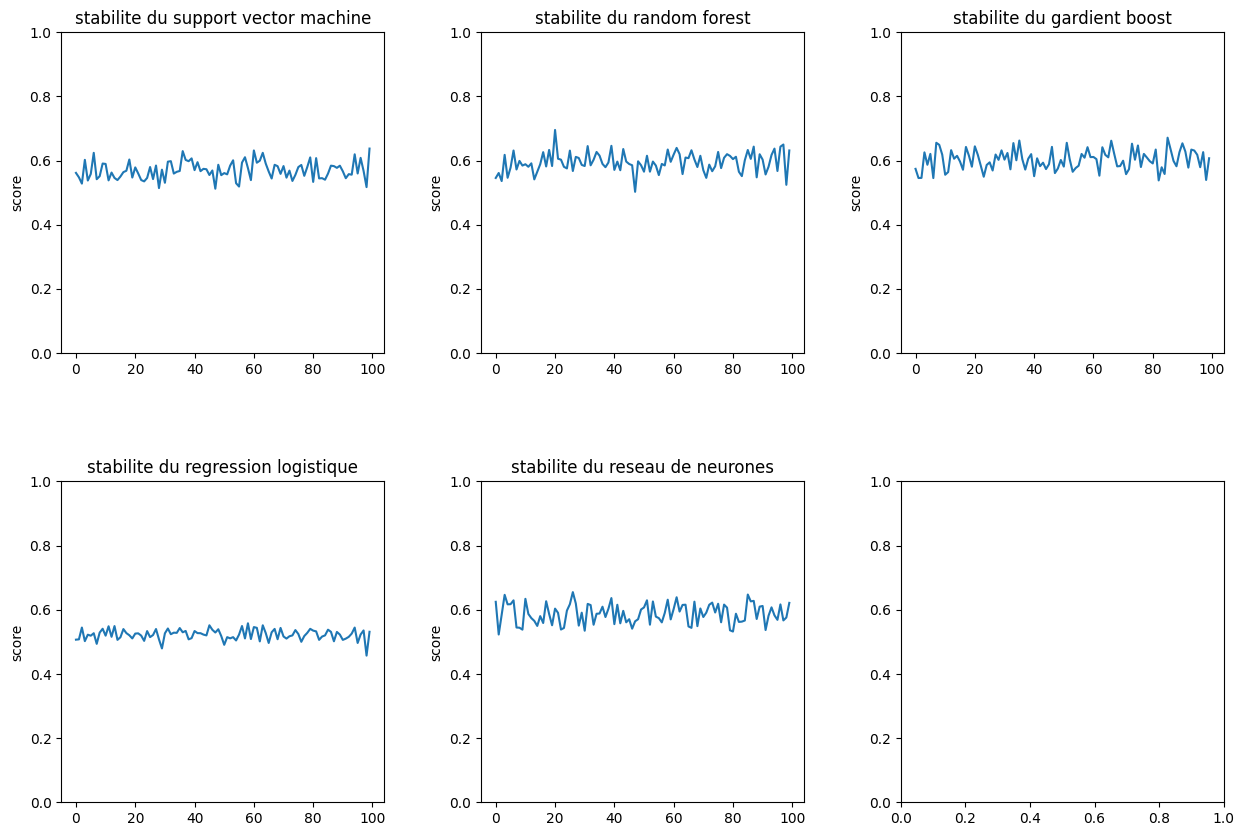

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.lineplot(data=data_svc['auc'], ax=axes[0, 0])
sns.lineplot(data=data_rf['auc'], ax=axes[0, 1])
sns.lineplot(data=data_gb['auc'], ax=axes[0, 2])
sns.lineplot(data=data_lr['auc'], ax=axes[1, 0])
sns.lineplot(data=data_mlp['auc'], ax=axes[1, 1])
axes[0, 0].set(title="stabilite du support vector machine", ylabel="score",ylim=(0,1))
axes[0, 1].set(title="stabilite du random forest", ylabel="score",ylim=(0,1))
axes[0, 2].set(title="stabilite du gardient boost",ylabel="score",ylim=(0,1))
axes[1, 0].set(title="stabilite du regression logistique",ylabel="score",ylim=(0,1))
axes[1, 1].set(title="stabilite du reseau de neurones", ylabel="score",ylim=(0,1))

plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()

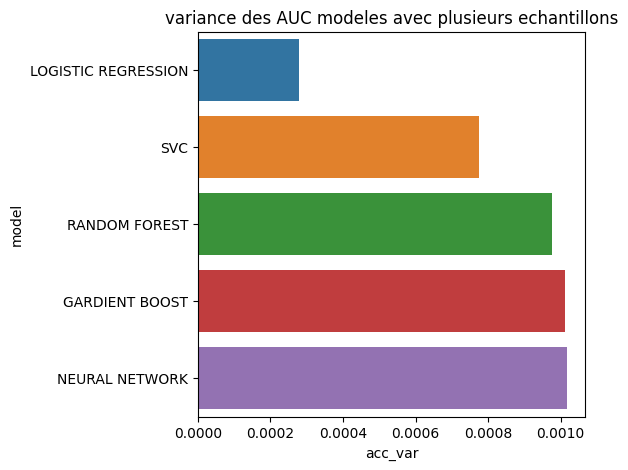

In [45]:
svc_var=data_svc['auc'].var()
rf_var=data_rf['auc'].var()
gb_var=data_gb['auc'].var()
lr_var=data_lr['auc'].var()
mlp_var=data_mlp['auc'].var()
data_var=pd.DataFrame({'model':['SVC','RANDOM FOREST','GARDIENT BOOST' ,'LOGISTIC REGRESSION','NEURAL NETWORK'],
                      'acc_var':[svc_var,rf_var,gb_var,lr_var,mlp_var] })
data_var.sort_values(by='acc_var',inplace=True)
plt.figure(figsize=(5,5))
sns.barplot(x=data_var['acc_var'],y=data_var['model'])
plt.title('variance des AUC modeles avec plusieurs echantillons')
plt.show()